# Improving Fast Minimum-Norm Attacks with Hyperparameter Optimization

In [1]:
import math
import torch

from src.models.load_data import load_data
from src.tuning.tune_fmn import tune_fmn
from src.attacks.fmn_opt import FMNOpt
from src.utils.show_image import show_image

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

Below the available models that can be tested, the optimizers and schedulers which can be used with this parametric implementation of FMN.

In [2]:
MODELS = {
    0: 'Wang2023Better_WRN-70-16',
    1: 'Wang2023Better_WRN-28-10',
    2: 'Gowal2021Improving_70_16_ddpm_100m',
    3: 'Rebuffi2021Fixing_106_16_cutmix_ddpm',
    4: 'Gowal2021Improving_28_10_ddpm_100m',
    5: 'Pang2022Robustness_WRN70_16',
    6: 'Sehwag2021Proxy_ResNest152',
    7: 'Pang2022Robustness_WRN28_10',
    8: 'Gowal2021Improving_R18_ddpm_100m'
}

OPTIMIZERS = {
    0: "SGD",
    1: "SGDNesterov",
    2: "Adam",
    3: "AdamAmsgrad"
}

SCHEDULERS = {
    0: "CosineAnnealingLR",
    1: "CosineAnnealingWarmRestarts",
    2: "MultiStepLR",
    3: "ReduceLROnPlateau"
}

LOSSES = {
    0: 'LL',    # Logit Loss
    1: 'CE'     # Cross Entropy Loss
}

Loading the model and the dataset (CIFAR10):

In [3]:
model_id = 8
batch_size = 50
dataset_percent = 0.5

# dataset: Cifar10, norm: LInf
model, dataset = load_data(model_id)

# load a subset of Cifar10 for tuning the attack
dataset_frac = list(range(0, math.floor(len(dataset)*dataset_percent)))
dataset_frac = torch.utils.data.Subset(dataset, dataset_frac)

data_loader = torch.utils.data.DataLoader(dataset_frac,
                                          batch_size=batch_size,
                                          shuffle=False)

Files already downloaded and verified


## Compute clean accuracy
Testing the model with the dataset used for tuning FMN

In [4]:
total, correct = 0.0, 0.0
for b, (inputs, labels) in enumerate(data_loader):
    inputs, labels = inputs.to(device), labels.to(device)
    pred = model(inputs).argmax(1)
    total += labels.shape[0]
    correct += (pred == labels).sum()
    if total >= 1000:
        break

print("Model name: {}".format(MODELS[model_id]))
print("Clean accuracy: {:.4f}".format(correct / total))

Model name: Gowal2021Improving_R18_ddpm_100m
Clean accuracy: 0.8810


## Tune FMN HyperParameters
Here we perform the tuning of the FMN hyperparameters. We first set the optimizer, the scheduler and the loss.


In [5]:
optimizer = OPTIMIZERS[0]   # SGD
scheduler = SCHEDULERS[0]   # CosineAnnealingLR
loss = LOSSES[0]            # LL
steps = 10
epochs = 1
num_samples = 1

fmn_best_config = tune_fmn(model=model,
                           data_loader=data_loader,
                           optimizer=optimizer,
                           scheduler=scheduler,
                           batch=batch_size,
                           steps=steps,
                           epochs=epochs,
                           num_samples=num_samples,
                           loss=loss)

2023-05-12 19:10:20,793	INFO tune.py:945 -- Total run time: 25.86 seconds (25.85 seconds for the tuning loop).


best_distance : 0.04643118381500244
, best config : {'opt_s': {'lr': 1.566261042027832, 'momentum': 0.9265078946397945, 'weight_decay': 0.05316409886511766, 'dampening': 0.07373189005362395}, 'sch_s': {'T_max': 10, 'eta_min': 0, 'last_epoch': -1}}



## Perform FMN attack using the best configuration
From the previous tuning we got the best configuration of hyperparameters for the optmizer and scheduler.
We run the attack using this configuration.

In [6]:
inputs, labels = next(iter(data_loader))

fmn_attack = FMNOpt(model=model,
                    inputs=inputs,
                    labels=labels,
                    norm='inf',
                    steps=20,
                    optimizer=optimizer,
                    scheduler=scheduler,
                    optimizer_config=fmn_best_config['opt_s'],
                    scheduler_config=fmn_best_config['sch_s'],
                    logit_loss = True if loss == 'LL' else False)

_, best_adv = fmn_attack.run(log=True)

Starting the attack...

Attack completion: 0.00%
Attack completion: 5.00%
Attack completion: 10.00%
Attack completion: 15.00%
Attack completion: 20.00%
Attack completion: 25.00%
Attack completion: 30.00%
Attack completion: 35.00%
Attack completion: 40.00%
Attack completion: 45.00%
Attack completion: 50.00%
Attack completion: 55.00%
Attack completion: 60.00%
Attack completion: 65.00%
Attack completion: 70.00%
Attack completion: 75.00%
Attack completion: 80.00%
Attack completion: 85.00%
Attack completion: 90.00%
Attack completion: 95.00%
Attack completed!



## Show original and perturbed images

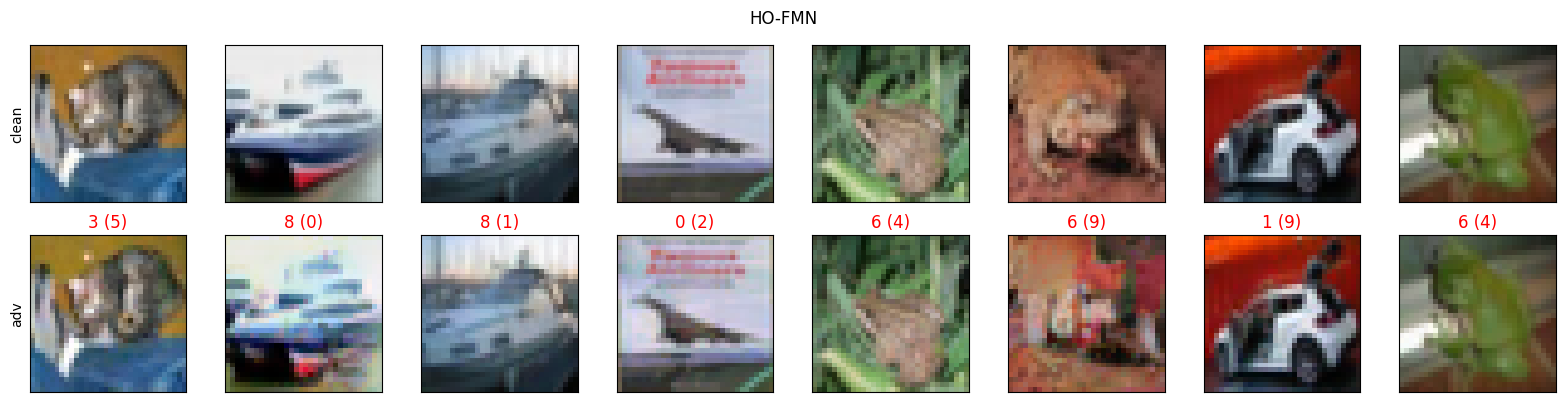

In [7]:
preds = model(best_adv).argmax(1)

img_shape = (3, 32, 32)
show_image('HO-FMN', inputs, best_adv, preds, labels, n_display=8, img_shape=img_shape)